# Assignment 2

This jupyter notebook contains the code for the second assignment.

Group members:
- Alessandro Pasi
- Matteo Belletti
- Stricescu Razvan Ciprian

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT

This Jupyter Notebook document is our implementation of Assignment 2. 

Group members:
- Stricescu Razvan Ciprian
- Matteo Belletti
- Alessandro Pasi

For models, further information and results, please refer to the report and github repository.
Github repository:
https://github.com/CipStr/NLProject

# Imports and libraries needed:

In [1]:
#%pip install pandas
#%pip install numpy
#%pip install nltk
#%pip install scikit-learn
#%pip install transformers
#%pip install matplotlib
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, f1_score, classification_report
import seaborn as sns
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, ConcatDataset
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, RobertaConfig
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

d:\NLProject\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## Task 1: Corpus:

We address a multi-label classification problem. We consider only level 3 categories which are the following:
- Openness to change
- Self-enhancement
- Conservation
- Self-transcendence

We're gonna merge annotations of level 2 categories belonging to the same level 3 category. For example, we merge the annotations of the level 2 categories "Stimulation" and "Hedonism" into the level 3 category "Openness to change".

Encoding data to pandas dataframe:

In [3]:
arg_train = pd.read_csv('arguments/arguments-training.tsv', sep='\t')
print(arg_train.head(1))
print(f"Shape of the training data: {arg_train.shape}")
arg_val = pd.read_csv('arguments/arguments-validation.tsv', sep='\t')
print(f"Shape of the validation data: {arg_val.shape}")
arg_test = pd.read_csv('arguments/arguments-test.tsv', sep='\t')
print(f"Shape of the test data: {arg_test.shape}")

  Argument ID                   Conclusion       Stance  \
0      A01002  We should ban human cloning  in favor of   

                                             Premise  
0  we should ban human cloning as it will only ca...  
Shape of the training data: (5393, 4)
Shape of the validation data: (1896, 4)
Shape of the test data: (1576, 4)


Encoding the labels to pandas dataframes:

In [4]:
lab_train = pd.read_csv('arguments/labels-training.tsv', sep='\t')
print(lab_train.head(1))
print(f"Shape of the training data: {lab_train.shape}")
lab_val = pd.read_csv('arguments/labels-validation.tsv', sep='\t')
print(f"Shape of the validation data: {lab_val.shape}")
lab_test = pd.read_csv('arguments/labels-test.tsv', sep='\t')
print(f"Shape of the test data: {lab_test.shape}")

  Argument ID  Self-direction: thought  Self-direction: action  Stimulation  \
0      A01002                        0                       0            0   

   Hedonism  Achievement  Power: dominance  Power: resources  Face  \
0         0            0                 0                 0     0   

   Security: personal  ...  Tradition  Conformity: rules  \
0                   0  ...          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   

   Universalism: tolerance  Universalism: objectivity  
0                        0                          0  

[1 rows x 21 columns]
Shape of the training data: (5393, 21)
Shape of the validation data: (1896, 21)
Shape of the test data: (1576, 21)


Now for each split we merge arguments and labels into a single dataframe.

In [5]:
df_train = arg_train.merge(lab_train, on='Argument ID')
df_val = arg_val.merge(lab_val, on='Argument ID')
df_test = arg_test.merge(lab_test, on='Argument ID')
print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the validation data: {df_val.shape}")
print(f"Shape of the test data: {df_test.shape}")

Shape of the training data: (5393, 24)
Shape of the validation data: (1896, 24)
Shape of the test data: (1576, 24)


We merge level 2 categories into level 3 categories. We also create new dataframes for the cp and cps tasks.

In [6]:
# Merge the level 2 categories to level 3
# They start from column 4 so we can just add 4 to the level 2 category
# Openness to change: 4 columns
# Conservation: columns 4 columns
# Self-enhancement: 6 columns
# Self-transcendence: 6 columns

def merge_categories(df):
    # Logical or 
    df['Openness to change'] = df[df.columns[4:8]].any(axis=1).astype(int)
    df['Conservation'] = df[df.columns[7:12]].any(axis=1).astype(int)
    df['Self-enhancement'] = df[df.columns[11:18]].any(axis=1).astype(int)
    df['Self-transcendence'] = df[df.columns[17:24]].any(axis=1).astype(int)
    df = df.drop(df.columns[4:24], axis=1)
    return df

# get column names
df_train = merge_categories(df_train)
df_val = merge_categories(df_val)
df_test = merge_categories(df_test)
print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the validation data: {df_val.shape}")
print(f"Shape of the test data: {df_test.shape}")

# Create the dataframes for the cp task
df_traincp = df_train.copy()
df_valcp = df_val.copy()
df_testcp = df_test.copy()
df_traincp["text"] = df_traincp["Conclusion"] + " " + df_traincp["Premise"]
df_valcp["text"] = df_valcp["Conclusion"] + " " + df_valcp["Premise"]
df_testcp["text"] = df_testcp["Conclusion"] + " " + df_testcp["Premise"]
print(f"Shape of the training data for the cp task: {df_traincp.shape}")

# Create the dataframes for the cps task
df_traincps = df_train.copy()
df_valcps = df_val.copy()
df_testcps = df_test.copy()
df_traincps["Stance"] = df_traincps["Stance"].replace("against", "0")
df_valcps["Stance"] = df_valcps["Stance"].replace("against", "0")
df_testcps["Stance"] = df_testcps["Stance"].replace("against", "0")
df_valcps["Stance"] = df_valcps["Stance"].replace("in favor of", "1")
df_traincps["Stance"] = df_traincps["Stance"].replace("in favor of", "1")
df_testcps["Stance"] = df_testcps["Stance"].replace("in favor of", "1")
df_traincps["text"] = df_traincp["Conclusion"] + " " + df_traincp["Premise"] + " " + df_traincps["Stance"]
df_valcps["text"] = df_valcp["Conclusion"] + " " + df_valcp["Premise"] + " " + df_valcps["Stance"]
df_testcps["text"] = df_testcp["Conclusion"] + " " + df_testcp["Premise"] + " " + df_testcps["Stance"]
print(f"Shape of the training data for the cps task: {df_traincps.shape}")

Shape of the training data: (5393, 8)
Shape of the validation data: (1896, 8)
Shape of the test data: (1576, 8)
Shape of the training data for the cp task: (5393, 9)
Shape of the training data for the cps task: (5393, 9)


#### Text encoding:

We encode the Premise column in order to check the sentence length distribution.

In [7]:
nltk.download('punkt')
train_text = df_train['Premise'].tolist()
train_lengths = [len(word_tokenize(x)) for x in tqdm(train_text)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 5393/5393 [00:00<00:00, 6739.73it/s]


Plotting the distribution of the number of words per argument:

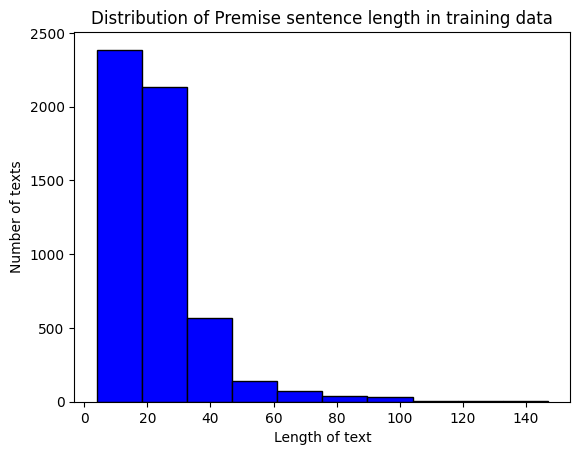

In [8]:
plt.hist(train_lengths, color='blue', edgecolor='black')
plt.xlabel('Length of text')
plt.ylabel('Number of texts')
plt.title('Distribution of Premise sentence length in training data')
plt.show()

We can see that the majority of the arguments have less than 100 words. We can set the maximum length of the arguments to 100 for padding.

Text preproccesing with nltk: 

We use nltk to remove stopwords and punctuation from the arguments and we also lemmitize the words.

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
punct = string.punctuation
bad_symbols = re.compile('[^a-z ]')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Text preprocessing: lowercasing, removing punctuation and stopwords, lemmatization:

In [10]:
def preprocess(text):
    text = text.lower()
    text = bad_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in punct)
    text = ' '.join(word for word in text.split() if word not in stopwords)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

We maninly use the following enmbeddings for the baseline models, as for the BERT model we use its own tokenizer.

In [11]:
train = df_train.copy()
train['Preprocessed'] = train['Premise'].apply(preprocess)
train = train.drop(columns=train.columns[1:4])
val = df_val.copy()
val['Preprocessed'] = val['Premise'].apply(preprocess)
val = val.drop(columns=val.columns[1:4])
test = df_test.copy()
test['Preprocessed'] = test['Premise'].apply(preprocess)
test = test.drop(columns=test.columns[1:4])
print(f"Train dataframe after preprocessing:\n")
train.head(1)

Train dataframe after preprocessing:



,Argument ID,Openness to change,Conservation,Self-enhancement,Self-transcendence,Preprocessed
0,A01002,0,0,1,0,ban human cloning cause huge issue bunch human...


We tokenize the the data using TF-IDF vectorizer. We do the same for the validation and test sets which we will use later for the baseline models.

In [12]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['Preprocessed'])
X_val = vectorizer.transform(val['Preprocessed'])
X_test = vectorizer.transform(test['Preprocessed'])

print(f"Shape of the training data: {X_train.shape}")
print(f"Shape of the validation data: {X_val.shape}")
print(f"Shape of the test data: {X_test.shape}")
print(f"Size of the vocabulary: {len(vectorizer.vocabulary_)}")

Shape of the training data: (5393, 6836)
Shape of the validation data: (1896, 6836)
Shape of the test data: (1576, 6836)
Size of the vocabulary: 6836


# Task 2: Model definition

You are tasked to define several neural models for multi-label classification.

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

Evaluation function that returns the classification report:

In [13]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred)
    return report

## Baseline models:

As baseline models we implemented a random uniform classifier and a majority classifier using the sklearn library which already has these models implemented.

We implement a classifier for each category.

Labels definition for the baseline models:

In [14]:
Y_test = test.iloc[:, 1:5].values # get as array the labels of the test set [oppenness, conservation, self-enhancement, self-transcendence]
Y_val = val.iloc[:, 1:5].values # get as array the labels of the validation set [oppenness, conservation, self-enhancement, self-transcendence]

### Implement a random uniform classifier:

In [15]:
from sklearn.dummy import DummyClassifier

uniform_classifier_openness = DummyClassifier(strategy='uniform')
uniform_classifier_conserv = DummyClassifier(strategy='uniform')
uniform_classifier_self_enh = DummyClassifier(strategy='uniform')
uniform_classifier_self_trans = DummyClassifier(strategy='uniform')

### Implement a majority classifier:

In [16]:
majority_classifier_openness = DummyClassifier(strategy='most_frequent')
majority_classifier_conserv = DummyClassifier(strategy='most_frequent')
majority_classifier_self_enh = DummyClassifier(strategy='most_frequent')
majority_classifier_self_trans = DummyClassifier(strategy='most_frequent')

## RoBERTa model:

As a BERT-based classifier we used the RoBERTa model. We used the HuggingFace library to load the model and the tokenizer. We chose the RoBERTa model because it is a more recent model than BERT and it is generally considered to be more versatile and robust.

Global variables and hyperparameters:

In [17]:
model_name = 'roberta-base'
max_len = 100
batch_size = 16
epochs = 10
learning_rate = 2e-5
output_channels = 768
tokenizer = AutoTokenizer.from_pretrained(model_name)
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']

As RoBERTa is a transformer model, we need to create custom data generators for the training, validation and test sets. Here we redefine the data generators for the RoBERTa model.

In [18]:
# This defines how the text is pre-processed before sending it to the neural network
class RobertaDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_len):
        self.data = data
        self.targets = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = str(self.data[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Create the dataset for the neural network
train_targets = df_train.iloc[:, 4:8].values
val_targets = df_val.iloc[:, 4:8].values
test_targets = df_test.iloc[:, 4:8].values

print(f"Shape of the training labels: {train_targets.shape}")
print(f"Shape of the validation labels: {val_targets.shape}")
print(f"Shape of the test labels: {test_targets.shape}")

Shape of the training labels: (5393, 4)
Shape of the validation labels: (1896, 4)
Shape of the test labels: (1576, 4)


RoBERTa model definition with the addition of a dropout layer and a classification layer that we use to calculate the loss and determine the accuracy of the predictions.

In [19]:
class roBERTa(torch.nn.Module):
    def __init__(self, model_name):
        super(roBERTa, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name, return_dict=False)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.classifier = torch.nn.Linear(output_channels, 4)
        
    def forward(self, ids, mask, token_type_ids):
        _, output = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

Loss function:

We use Binary Cross Entropy as loss function instead of Categorical Cross Entropy because we have a multi-label classification problem and we need to compute the probability of each label independently as they are not mutually exclusive.

In [20]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

### For each model we create different datasets and dataloaders based on the task we are performing, more specifically:
- **C**: we only use the conclusion of the argument as input.
- **CP**: we use the premise and the conclusion of the argument as input.
- **CPS**: we use the premise, the conclusion and the stance of the argument as input.

RoBERTa w/C data preparation:

In [21]:
train_datasetc = RobertaDataset(df_train.iloc[:, 1], train_targets, tokenizer, max_len)
val_datasetc = RobertaDataset(df_val.iloc[:, 1], val_targets, tokenizer, max_len)
test_datasetc = RobertaDataset(df_test.iloc[:, 1], test_targets, tokenizer, max_len)

print(f"Shape of the training dataset: {len(train_datasetc)}")
print(f"Shape of the validation dataset: {len(val_datasetc)}")
print(f"Shape of the test dataset: {len(test_datasetc)}")

# Definiition of the Dataloader that will feed the data in batches to the neural network for suitable training and processing.
train_dataloaderc = DataLoader(train_datasetc, batch_size=batch_size)
val_dataloaderc = DataLoader(val_datasetc, batch_size=batch_size)
test_dataloaderc = DataLoader(test_datasetc, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


RoBERTa w/CP data preparation:

In [22]:
train_datasetcp = RobertaDataset(df_traincp.iloc[:, 8], train_targets, tokenizer, max_len)
val_datasetcp = RobertaDataset(df_valcp.iloc[:, 8], val_targets, tokenizer, max_len)
test_datasetcp = RobertaDataset(df_testcp.iloc[:, 8], test_targets, tokenizer, max_len)


print(f"Shape of the training dataset: {len(train_datasetcp)}")
print(f"Shape of the validation dataset: {len(val_datasetcp)}")
print(f"Shape of the test dataset: {len(test_datasetcp)}")

train_dataloadercp = DataLoader(train_datasetcp, batch_size=batch_size)
val_dataloadercp = DataLoader(val_datasetcp, batch_size=batch_size)
test_dataloadercp = DataLoader(test_datasetcp, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


RoBERTa w/CPS data preparation:

In [23]:
train_datasetcps = RobertaDataset(df_traincps.iloc[:, 8], train_targets, tokenizer, max_len)
val_datasetcps = RobertaDataset(df_valcps.iloc[:, 8], val_targets, tokenizer, max_len)
test_datasetcps = RobertaDataset(df_testcps.iloc[:, 8], test_targets, tokenizer, max_len)


print(f"Shape of the training dataset: {len(train_datasetcps)}")
print(f"Shape of the validation dataset: {len(val_datasetcps)}")
print(f"Shape of the test dataset: {len(test_datasetcps)}")

train_dataloadercps = DataLoader(train_datasetcps, batch_size=batch_size)
val_dataloadercps = DataLoader(val_datasetcps, batch_size=batch_size)
test_dataloadercps = DataLoader(test_datasetcps, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


### Model initialization:

We initialize the models and we move them to the GPU or CPU depending on the availability. We initialize them in different cells so training can be done separately for each model as they can take a long time to train.

In [24]:
model_c = roBERTa(model_name)
model_c.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [25]:
model_cp = roBERTa(model_name)
model_cp.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [26]:
model_cps = roBERTa(model_name)
model_cps.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

### Training function for RoBERTa models:

Since we have 3 different models we created a function that performs training given the model and the training dataloader. The training loop is quite standard. We use the Adam optimizer and the BCEWithLogitsLoss loss function. We also use the scheduler to decrease the learning rate during training.

In [27]:
def trainBert(model, dataloader):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader)*epochs)
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(ids)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Validation function for RoBERTa models:

We also created a function that evaluates a model given the model and the validation dataloader. Again, the validation loop is quite standard. We compute the loss for each batch and then we average it while also saving the model in case the validation loss is lower than the previous one, like a checkpoint.

In [28]:
def validation(epoch, val_loss_min_input, model, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()
        
        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0: 
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')   
            # save best moel
            torch.save(model.state_dict(), "model.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss
    
    return val_loss_min_input

# Task 3: Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

We make heavy use of the sklearn library to compute the metrics, especially the f1 score, for each model as it is already implemented and it is quite easy to use.

### Random uniform classifier metrics:

We compute the f1 score for each category and the macro f1 score for the random uniform classifier.

In [29]:
def f1scoreRandom(X_val, Y_val):
    Y_pred_openness_unif = uniform_classifier_openness.predict(X_val)
    Y_pred_conserv_unif = uniform_classifier_conserv.predict(X_val)
    Y_pred_self_enh_unif = uniform_classifier_self_enh.predict(X_val)
    Y_pred_self_trans_unif = uniform_classifier_self_trans.predict(X_val)
    
    Y_pred = []
    for i in range(len(Y_pred_openness_unif)):
        temp = []
        temp.append(Y_pred_openness_unif[i])
        temp.append(Y_pred_conserv_unif[i])
        temp.append(Y_pred_self_enh_unif[i])
        temp.append(Y_pred_self_trans_unif[i])
        Y_pred.append(temp)
        
    return evaluate(Y_val, Y_pred)

### Majority classifier metrics:

we compute the f1 score for each category and the macro f1 score for the majority classifier.

In [30]:
def f1scoreMajority(X_val, Y_val):
    Y_pred_openness_maj = majority_classifier_openness.predict(X_val)
    Y_pred_conserv_maj = majority_classifier_conserv.predict(X_val)
    Y_pred_self_enh_maj = majority_classifier_self_enh.predict(X_val)
    Y_pred_self_trans_maj = majority_classifier_self_trans.predict(X_val)

    Y_pred = []
    for i in range(len(Y_pred_openness_maj)):
        temp = []
        temp.append(Y_pred_openness_maj[i])
        temp.append(Y_pred_conserv_maj[i])
        temp.append(Y_pred_self_enh_maj[i])
        temp.append(Y_pred_self_trans_maj[i])
        Y_pred.append(temp)
        
    return evaluate(Y_val, Y_pred)

### RoBERTa model metrics:

The test function is used to evaluate the model on a given dataset. We simply compute the predictions and we return them along with the true labels.

In [31]:
def test(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad(): # no need to calculate the gradients
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

This function is used to compute the best threshold for a given model and a given dataset. We compute the f1 score for each threshold and we return the best one.

In [32]:
def get_threshold(model, dataloader):
    outputs, targets = test(model, dataloader)
    results = {}
    for tr in np.arange(0.1, 0.9, 0.1):
        tr = round(tr, 2)
        predictions= np.array(outputs) >= tr
        f1 = f1_score(targets, predictions, average='macro', zero_division=1)
        results[tr] = f1

    #for k, v in results.items():
        # print(f"Threshold: {k}, F1-score: {v}")
    return max(results, key=results.get), results, outputs, targets

# Task 4: Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

Seed definition:

In [33]:
# Seed definition
#seed = 42
#seed = 69
seed = 420

# Set the seed for numpy to have reproducible experiments
np.random.seed(seed)

### Train the random uniform classifier:

In [34]:

Y_train_openness = train['Openness to change']
Y_train_conserv = train['Conservation']
Y_train_self_enh = train['Self-enhancement']
Y_train_self_trans = train['Self-transcendence']
uniform_classifier_openness.fit(X_train, Y_train_openness)
uniform_classifier_conserv.fit(X_train, Y_train_conserv)
uniform_classifier_self_enh.fit(X_train, Y_train_self_enh)
uniform_classifier_self_trans.fit(X_train, Y_train_self_trans)
report_ruc = f1scoreRandom(X_val, Y_val)
print("Classification report for the random classifier:\n")
print(report_ruc)

Classification report for the random classifier:

              precision    recall  f1-score   support

           0       0.37      0.49      0.42       698
           1       0.47      0.51      0.49       885
           2       0.75      0.50      0.60      1426
           3       0.79      0.52      0.62      1506

   micro avg       0.60      0.50      0.55      4515
   macro avg       0.59      0.50      0.53      4515
weighted avg       0.65      0.50      0.56      4515
 samples avg       0.56      0.51      0.49      4515



d:\NLProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Train the majority classifier:

In [35]:
majority_classifier_openness.fit(X_train, Y_train_openness)
majority_classifier_conserv.fit(X_train, Y_train_conserv)
majority_classifier_self_enh.fit(X_train, Y_train_self_enh)
majority_classifier_self_trans.fit(X_train, Y_train_self_trans)
report_mc = f1scoreMajority(X_val, Y_val)
print("Classification report for the majority classifier:\n")
print(report_mc)

Classification report for the majority classifier:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       698
           1       0.00      0.00      0.00       885
           2       0.75      1.00      0.86      1426
           3       0.79      1.00      0.89      1506

   micro avg       0.77      0.65      0.71      4515
   macro avg       0.39      0.50      0.44      4515
weighted avg       0.50      0.65      0.57      4515
 samples avg       0.77      0.68      0.70      4515



d:\NLProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## To skip the training and load the models go to task 5.

### Training RoBERTa w/C:

In [ ]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_c, train_dataloaderc)
    val_loss_min = validation(epoch, val_loss_min, model_c, train_dataloaderc)

### RoBERTa w/C evaluation:

In [ ]:
th, results_c, outputs_c, targets_c= get_threshold(model_c, val_dataloaderc)
print(f"Best threshold: {th}, F1-score: {results_c[th]}")
predictions_c = np.array(outputs_c) >= th
report_roberta_c = classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1)
print(report_roberta_c)

### Training RoBERTa w/CP:

In [40]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_cp, train_dataloadercp)
    val_loss_min = validation(epoch, val_loss_min, model_cp, train_dataloadercp)

Epoch 1
-------------------------------
Train loss: 0.703765  [    0/ 5393]
Train loss: 0.583361  [ 1600/ 5393]
Train loss: 0.528497  [ 3200/ 5393]
Train loss: 0.531994  [ 4800/ 5393]

Validation loss: 0.462537.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 0.571636  [    0/ 5393]
Train loss: 0.351225  [ 1600/ 5393]
Train loss: 0.554982  [ 3200/ 5393]
Train loss: 0.365206  [ 4800/ 5393]

Validation loss: 0.393426.
Validation loss decreased (0.46253744 --> 0.39342580).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
Train loss: 0.464953  [    0/ 5393]
Train loss: 0.298749  [ 1600/ 5393]
Train loss: 0.488705  [ 3200/ 5393]
Train loss: 0.282428  [ 4800/ 5393]

Validation loss: 0.337891.
Validation loss decreased (0.39342580 --> 0.33789086).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 4
-------------------------------
Train loss: 0.312650  [    0/ 5393]
Train

In [42]:
th, results_cp, outputs_cp, targets_cp= get_threshold(model_cp, val_dataloadercp)
print(f"Best threshold: {th}, F1-score: {results_cp[th]}")
predictions_cp = np.array(outputs_cp) >= th
report_roberta_cp = classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1)
print(report_roberta_cp)

Best threshold: 0.1, F1-score: 0.7664998271281073
                    precision    recall  f1-score   support

Openness to change       0.63      0.67      0.65       698
      Conservation       0.66      0.73      0.69       885
  Self-enhancement       0.76      0.99      0.86      1426
Self-transcendence       0.83      0.91      0.87      1506

         micro avg       0.74      0.86      0.80      4515
         macro avg       0.72      0.82      0.77      4515
      weighted avg       0.74      0.86      0.80      4515
       samples avg       0.77      0.88      0.79      4515



### Training RoBERTa w/CPS:

In [ ]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_cps, train_dataloadercp)
    val_loss_min = validation(epoch, val_loss_min, model_cps, train_dataloadercp)

Epoch 1
-------------------------------
Train loss: 0.703765  [    0/ 5393]
Train loss: 0.583361  [ 1600/ 5393]
Train loss: 0.528497  [ 3200/ 5393]
Train loss: 0.531994  [ 4800/ 5393]

Validation loss: 0.462537.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 0.571636  [    0/ 5393]
Train loss: 0.351225  [ 1600/ 5393]
Train loss: 0.554982  [ 3200/ 5393]
Train loss: 0.365206  [ 4800/ 5393]

Validation loss: 0.393426.
Validation loss decreased (0.46253744 --> 0.39342580).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
Train loss: 0.464953  [    0/ 5393]
Train loss: 0.298749  [ 1600/ 5393]
Train loss: 0.488705  [ 3200/ 5393]
Train loss: 0.282428  [ 4800/ 5393]

Validation loss: 0.337891.
Validation loss decreased (0.39342580 --> 0.33789086).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 4
-------------------------------
Train loss: 0.312650  [    0/ 5393]
Train

In [ ]:
th, results_cps, outputs_cps, targets_cps= get_threshold(model_cps, val_dataloadercps)
print(f"Best threshold: {th}, F1-score: {results_cps[th]}")
predictions_cps = np.array(outputs_cps) >= th
report_roberta_cps = classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1)
print(report_roberta_cps)

Best threshold: 0.1, F1-score: 0.7664998271281073
                    precision    recall  f1-score   support

Openness to change       0.63      0.67      0.65       698
      Conservation       0.66      0.73      0.69       885
  Self-enhancement       0.76      0.99      0.86      1426
Self-transcendence       0.83      0.91      0.87      1506

         micro avg       0.74      0.86      0.80      4515
         macro avg       0.72      0.82      0.77      4515
      weighted avg       0.74      0.86      0.80      4515
       samples avg       0.77      0.88      0.79      4515



# Task 5: Error Analysis


### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

We decided to load the current seed models as the difference in performance between seeds is not as much as we expected.

All the other seeds metrics are saved in the seed folder.

Model loading:

In [36]:
# load the models:
model_c.load_state_dict(torch.load(f'seed_{seed}/model_c_{seed}.pth', map_location=torch.device('cpu')))
model_cp.load_state_dict(torch.load(f'seed_{seed}/model_cp_{seed}.pth', map_location=torch.device('cpu')))
model_cps.load_state_dict(torch.load(f'seed_{seed}/model_cps_{seed}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

We get the predictions for each model and we compute the report for each one in order to compare them.

In [37]:
#get results:
th, results_c, outputs_c, targets_c= get_threshold(model_c, val_dataloaderc)
predictions_c = np.array(outputs_c) >= th
report_roberta_c = classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1)

th, results_cp, outputs_cp, targets_cp= get_threshold(model_cp, val_dataloadercp)
predictions_cp = np.array(outputs_cp) >= th
report_roberta_cp = classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1)

th, results_cps, outputs_cps, targets_cps= get_threshold(model_cps, val_dataloadercps)
predictions_cps = np.array(outputs_cps) >= th
report_roberta_cps = classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1)

We create a dataframe in order to better visualize the results.

In [38]:
# create a dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Openess to change', 'Conservation', 'Self-enhancement', 'Self-transcendence', 'Macro avg'])
results.loc[0] = ['Random', report_ruc.splitlines()[2].split()[3], report_ruc.splitlines()[3].split()[3], report_ruc.splitlines()[4].split()[3], report_ruc.splitlines()[5].split()[3], report_ruc.splitlines()[8].split()[4]]
results.loc[1] = ['Majority', report_mc.splitlines()[2].split()[3], report_mc.splitlines()[3].split()[3], report_mc.splitlines()[4].split()[3], report_mc.splitlines()[5].split()[3], report_mc.splitlines()[8].split()[4]]
results.loc[2] = ['roBERTa w/C', report_roberta_c.splitlines()[2].split()[3], report_roberta_c.splitlines()[3].split()[3], report_roberta_c.splitlines()[4].split()[3], report_roberta_c.splitlines()[5].split()[3], report_roberta_c.splitlines()[8].split()[4]]
results.loc[3] = ['roBERTa w/CP', report_roberta_cp.splitlines()[2].split()[3], report_roberta_cp.splitlines()[3].split()[3], report_roberta_cp.splitlines()[4].split()[3], report_roberta_cp.splitlines()[5].split()[3], report_roberta_cp.splitlines()[8].split()[4]]
results.loc[4] = ['roBERTa w/CPS', report_roberta_cps.splitlines()[2].split()[3], report_roberta_cps.splitlines()[3].split()[3], report_roberta_cps.splitlines()[4].split()[3], report_roberta_cps.splitlines()[5].split()[3], report_roberta_cps.splitlines()[8].split()[4]]
results.to_csv(f'seed_{seed}/results_{seed}.csv', index=False)

print("The F1-scores for the test set on the different models are the following:\n")
print(results)

The F1-scores for the test set on the different models are the following:

           Model Openess to change Conservation Self-enhancement  \
0         Random              0.42         0.49             0.60   
1       Majority              0.00         0.00             0.86   
2    roBERTa w/C              0.40         0.64             0.86   
3   roBERTa w/CP              0.68         0.69             0.87   
4  roBERTa w/CPS              0.59         0.69             0.87   

  Self-transcendence Macro avg  
0               0.62      0.53  
1               0.89      0.44  
2               0.89      0.73  
3               0.86      0.76  
4               0.88      0.77  


As we can see all three RoBERTa models outperform the baseline models by a large margin. The best performing model is the RoBERTa w/CPS model as it has more information to work with. One thing to note is that the RoBERTa w/C model struggles to predict the "Openness to change" category, this is probably because the conclusion of the argument is not enough to predict this category. 

This function is purely for visualization purposes.

In [39]:
def set_color(number_of_colors):
    # return a random color to be used for the plot
    color_list = []
    for i in range(number_of_colors):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return color_list

Here we plot the classification report for each model.

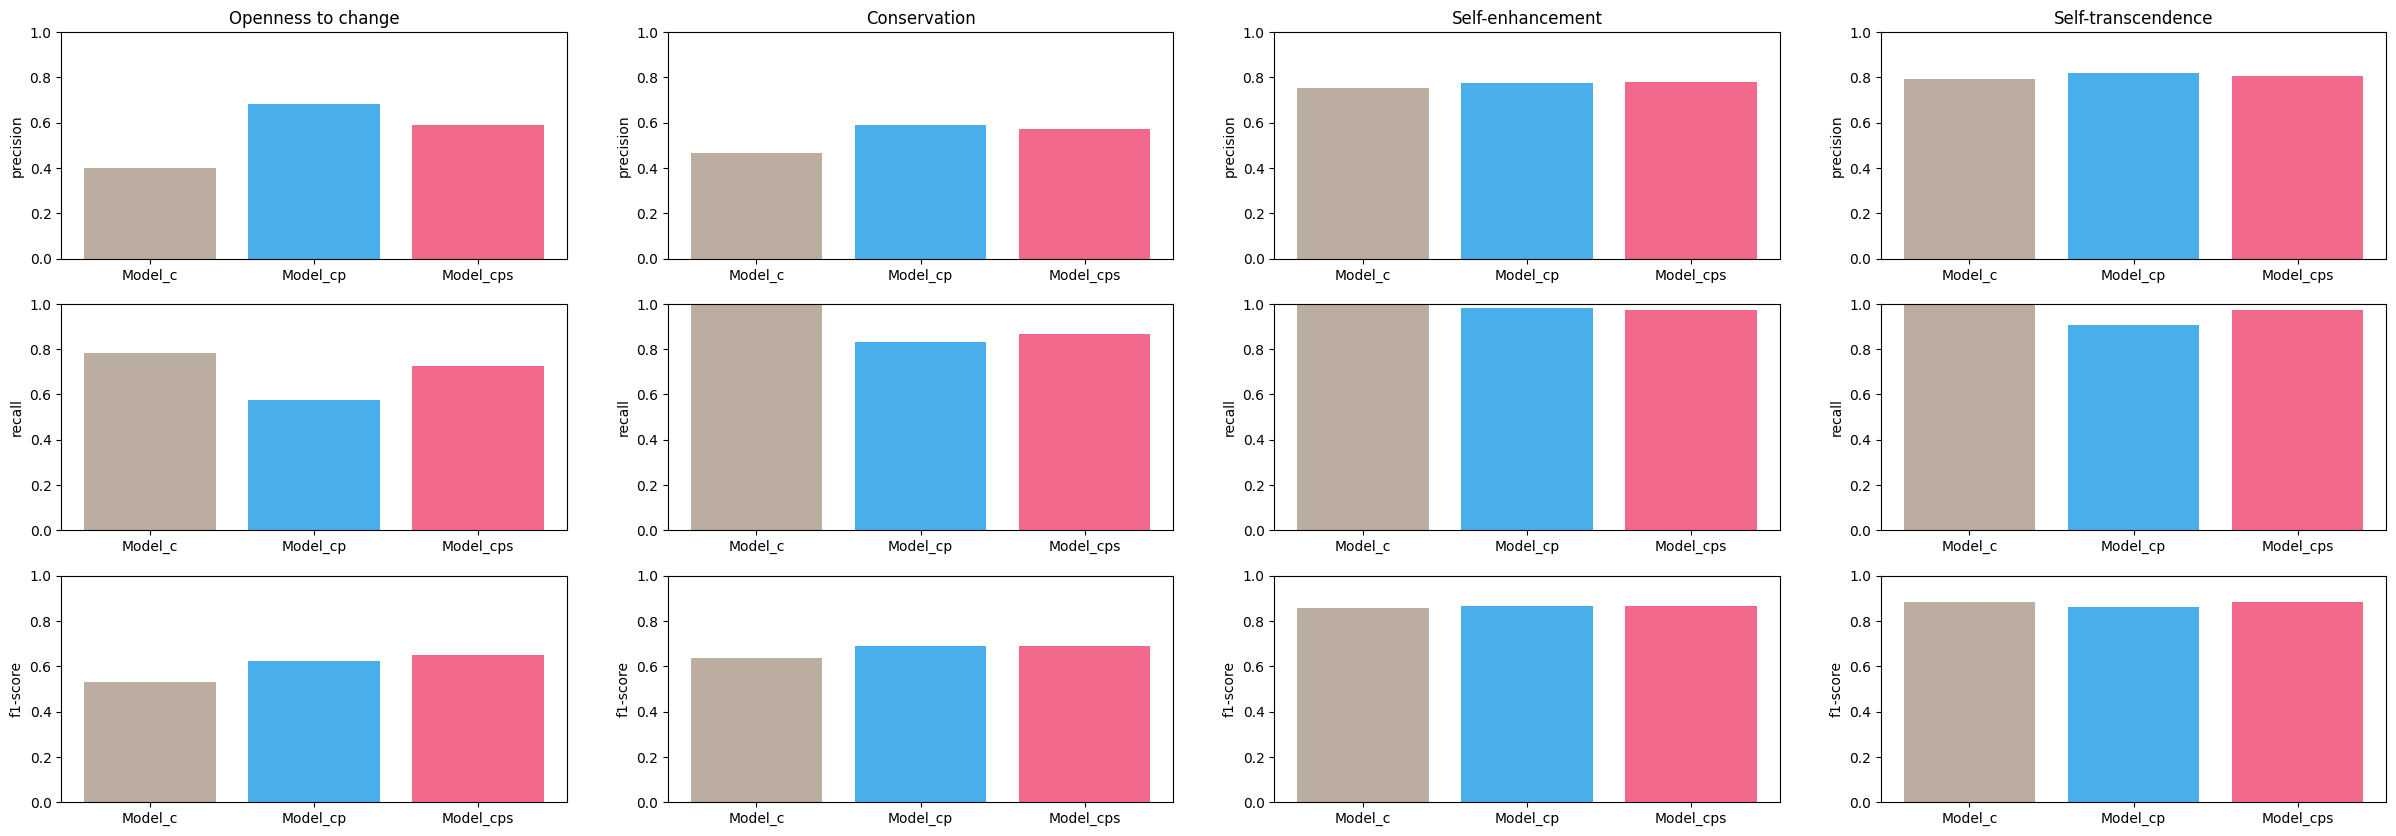

In [40]:
# for each model I plot the f1-score of each category for the test set using classification_report

report_results_c = classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1, output_dict=True)
report_results_cp = classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1, output_dict=True)
report_results_cps = classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1, output_dict=True)
all_reports = [report_results_c, report_results_cp, report_results_cps]

plot_colors = set_color(len(all_reports))

# I plot the precision, recall and f1-score for each category for each model.
fig, axs = plt.subplots(3, len(labels), figsize=(30, 10))

for i, metric in enumerate(['precision', 'recall', 'f1-score']):
    for j, label in enumerate(labels):
        for k, report in enumerate(all_reports):
            axs[i, j].bar(k, report[label][metric], color=plot_colors[k])
            if k == 0 : axs[k, j].set_title(label)
            axs[k, j].set_xticks([0, 1, 2])
            axs[k, j].set_xticklabels(['Model_c', 'Model_cp', 'Model_cps'])
            axs[k, j].set_ylim([0, 1])
            axs[i, j].set_ylabel(metric)
plt.show()


Like we said before, the RoBERTa w/CPS model outperforms the other two models in terms of f1 score. Another thing to note are the values for precision and recall. Just looking at the first label we can see:
- RoBERTa w/C has the lowest precision and highest recall. This means that it tends to predict a large number of positive instances but it is not very accurate.
- RoBERTa w/CP is an improvement over the previous model as it has a higher precision and a lower recall.
- RoBERTa w/CPS while not having the highest precision not the highest recall, it has the best balance between the two. 

All these results could maybe be improved by fine-tuning the models more or by trying different BERT variants. Also longer training sessions could improve the results.

### Most/least frequent labels scores:

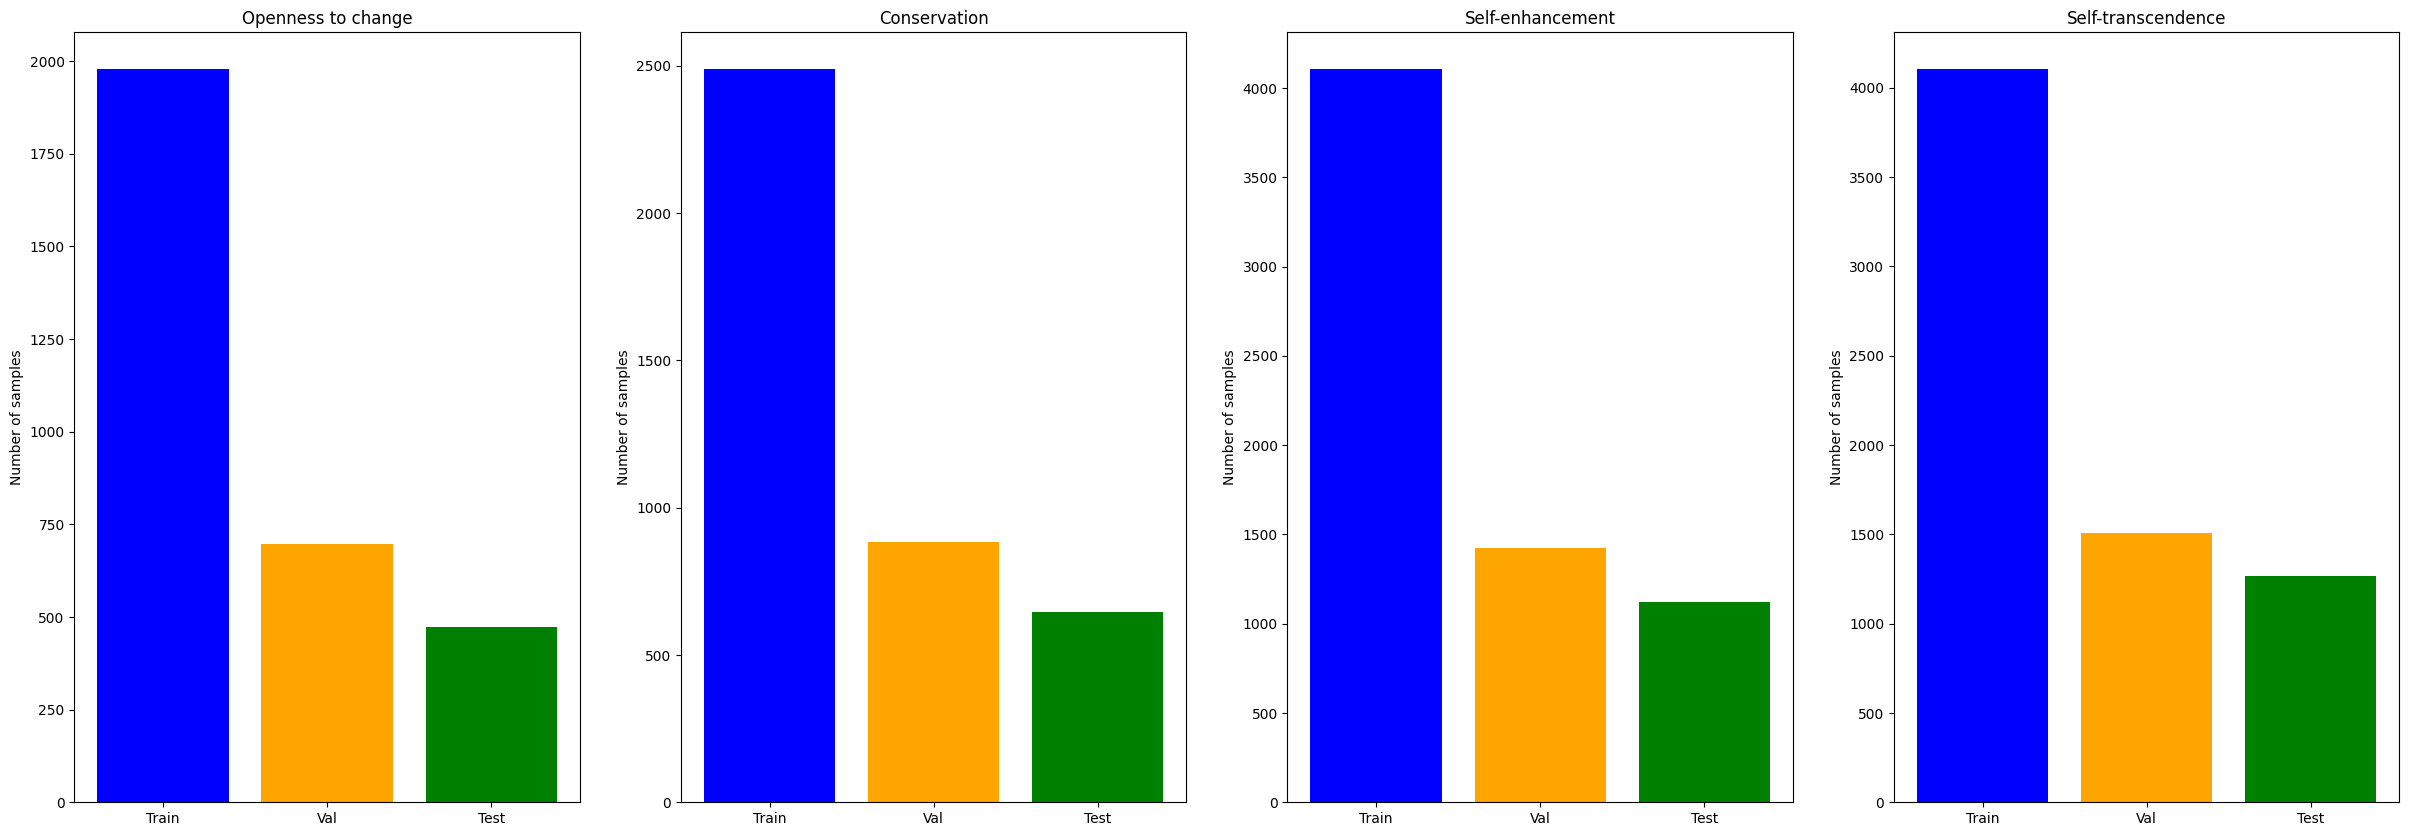

In [44]:
# plot label distribution
fig, axs = plt.subplots(1, len(labels), figsize=(30, 10))
for i, label in enumerate(labels):
    axs[i].bar(0, df_train[label].sum(), color='blue')
    axs[i].bar(1, df_val[label].sum(), color='orange')
    axs[i].bar(2, df_test[label].sum(), color='green')
    axs[i].set_xticks([0, 1, 2])
    axs[i].set_xticklabels(['Train', 'Val', 'Test'])
    axs[i].set_title(label)
    axs[i].set_ylabel('Number of samples')
plt.show()

Here we see the label distribution for all the datasets.

In [41]:
# Get most frequent label 
labels_temp = labels.copy()
opn_count = df_train['Openness to change'].sum()
cons_count = df_train['Conservation'].sum()
self_enh_count = df_train['Self-enhancement'].sum()
self_trans_count = df_train['Self-transcendence'].sum()
label_counts = [opn_count, cons_count, self_enh_count, self_trans_count]
print(f"Most frequent label is: {labels[np.argmax(label_counts)]}")
print(f"least frequent label is: {labels[np.argmin(label_counts)]}\n")
labels_temp.pop(np.argmax(label_counts))
labels_temp.pop(np.argmin(label_counts))

# Get the f1-score for the most frequent label
most_least_df = results.copy()
# drop baseline models
most_least_df = most_least_df.drop([0, 1])
# drop columns that are in the labels_temp list
most_least_df = most_least_df.drop(labels_temp, axis=1)
# rename the columns
print(most_least_df)

Most frequent label is: Self-enhancement
least frequent label is: Openness to change

           Model Openess to change Self-enhancement Macro avg
2    roBERTa w/C              0.40             0.86      0.73
3   roBERTa w/CP              0.68             0.87      0.76
4  roBERTa w/CPS              0.59             0.87      0.77


Here we can see that for the most frequent labels the models perform better than for the least frequent ones. This is probably because the models are trained on more data for the Self-enhancement category. One thing to note is that the RoBERTa w/CPS model has a lower f1 score for the Openess to change category than the RoBERTa w/CP model. This is probably because the RoBERTa w/CPS model has more information to work with and it tends to predict more positive instances for this category, thus maybe lowering the precision.

All three models seem to do very well on the most frequent label, with results being really similar. One way to solve this big discrepancy in f1 score between the most frequent and least frequent labels would be to use a weighted loss function.

### Confusion matrix for the RoBERTa models:

Here we plot the confusion matrix for the RoBERTa models on the test set. To compute the confusion matrix we use a function from the sklearn library called multilabel_confusion_matrix. 

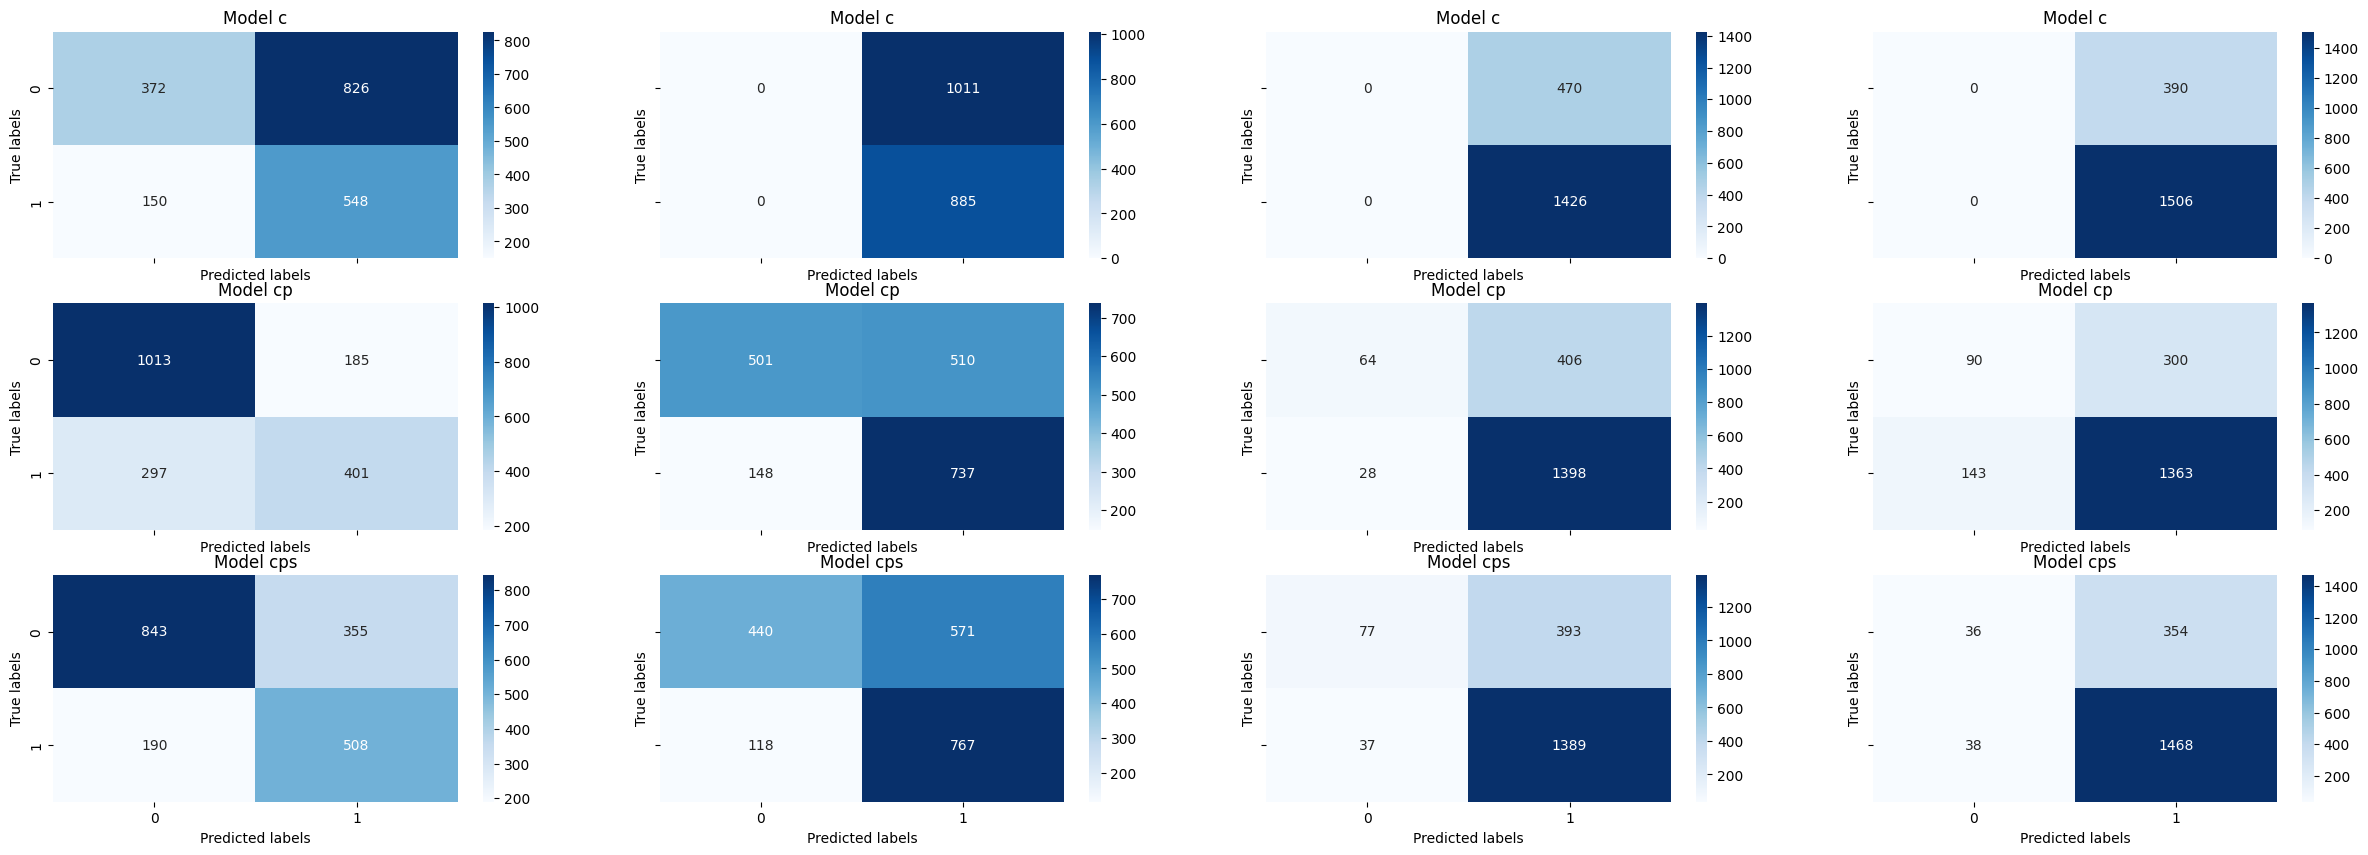

In [43]:
cm_c = multilabel_confusion_matrix(targets_c, predictions_c)
cm_cp = multilabel_confusion_matrix(targets_cp, predictions_cp)
cm_cps = multilabel_confusion_matrix(targets_cps, predictions_cps)
all_cms = [cm_c, cm_cp, cm_cps]
models = ['Model c', 'Model cp', 'Model cps']
# plot the confusion matrix for each category and each model as a heatmap also add model name as title
fig, axs = plt.subplots(3, len(labels), figsize=(30, 10), sharex=True, sharey=True)
for i, label in enumerate(labels):
    for j, cm in enumerate(all_cms):
        sns.heatmap(cm[i], annot=True, ax=axs[j, i], cmap='Blues', fmt='g')
        if j == 0 : axs[j, i].set_title(label)
        axs[j, i].set_xlabel('Predicted labels')
        axs[j, i].set_ylabel('True labels')
        axs[j][i].set_title(f"{models[j]}")
plt.show()

From these confusion matrices we can extract some interesting information:
- The RoBERTa w/C model tends to predict way more false positives than the other two models. This is probably because it only uses the conclusion of the argument as input.
- The RoBERTa w/CP model tends to predict more false negatives than the other two models, but performs better than the fist model overall. We think this is because it is getting more balanced.
- The RoBERTa w/CPS model has the best balance between false positives and false negatives. It also has the best f1 score out of the three models.
- There are way more true negatives than true positives for the "Self-transcendence" and "Self-enhancement" categories. This is something interesting to note as they are the only categories that have this property.

### Specific misclassifications for the RoBERTa models:

Here we present some specific misclassfications done by the RoBERTa models on the test set.

In [46]:
# get misclassified examples:

# get the indices of the misclassified examples
misclassified_c = np.where(predictions_c != targets_c)[0]
misclassified_cp = np.where(predictions_cp != targets_cp)[0]
misclassified_cps = np.where(predictions_cps != targets_cps)[0]

print(f"Number of misclassified examples for model_c: {len(misclassified_c)}")
print(f"Number of misclassified examples for model_cp: {len(misclassified_cp)}")
print(f"Number of misclassified examples for model_cps: {len(misclassified_cps)}")

# get the misclassified examples
misclassified_examples_c = df_test.iloc[misclassified_c[0]]
print(f"\nExample of misclassified example for model_c:\n")
print(misclassified_examples_c)
print("\n")
print(f"Predicted labels: {predictions_c[misclassified_c[0]].astype(float)}")
print(f"True labels: {targets_c[misclassified_c[0]]}")

misclassified_examples_cp = df_test.iloc[misclassified_cp[0]]
print(f"\nExample of misclassified example for model_cp:\n")
print(misclassified_examples_cp)
print("\n")
print(f"Predicted labels: {predictions_cp[misclassified_cp[0]].astype(float)}")
print(f"True labels: {targets_cp[misclassified_cp[0]]}")

misclassified_examples_cps = df_test.iloc[misclassified_cps[0]]
print(f"\nExample of misclassified example for model_cps:\n")
print(misclassified_examples_cps)
print("\n")
print(f"Predicted labels: {predictions_cps[misclassified_cps[0]].astype(float)}")
print(f"True labels: {targets_cps[misclassified_cps[0]]}")

Number of misclassified examples for model_c: 2847
Number of misclassified examples for model_cp: 2017
Number of misclassified examples for model_cps: 2056

Example of misclassified example for model_c:

Argument ID                                                     A26004
Conclusion                            We should end affirmative action
Stance                                                         against
Premise               affirmative action helps with employment equity.
Openness to change                                                   0
Conservation                                                         1
Self-enhancement                                                     1
Self-transcendence                                                   1
Name: 0, dtype: object


Predicted labels: [0. 1. 1. 1.]
True labels: [0.0, 0.0, 1.0, 0.0]

Example of misclassified example for model_cp:

Argument ID                                                     A26004
Conclusion       

As we can see the all three models struggle in these cases with the "Conservation" category. This is because together with "Openness to change" they are the least represented categories in the dataset.

## Precision/recall curves for the RoBERTa models:

As plotting multi-label precision/recall curves is not easily done we plot the individual precision/recall curves for each label for each model.

In [47]:
# get predictions for the openess to change category
predictions_openness_c = []
predictions_openness_cp = []
predictions_openness_cps = []
predictions_conserv_c = []
predictions_conserv_cp = []
predictions_conserv_cps = []
predictions_self_enh_c = []
predictions_self_enh_cp = []
predictions_self_enh_cps = []
predictions_self_trans_c = []
predictions_self_trans_cp = []
predictions_self_trans_cps = []

for i in range(len(targets_c)):
    predictions_openness_c.append(predictions_c[i][0].astype(float))
    predictions_openness_cp.append(predictions_cp[i][0].astype(float))
    predictions_openness_cps.append(predictions_cps[i][0].astype(float))
    predictions_conserv_c.append(predictions_c[i][1].astype(float))
    predictions_conserv_cp.append(predictions_cp[i][1].astype(float))
    predictions_conserv_cps.append(predictions_cps[i][1].astype(float))
    predictions_self_enh_c.append(predictions_c[i][2].astype(float))
    predictions_self_enh_cp.append(predictions_cp[i][2].astype(float))
    predictions_self_enh_cps.append(predictions_cps[i][2].astype(float))
    predictions_self_trans_c.append(predictions_c[i][3].astype(float))
    predictions_self_trans_cp.append(predictions_cp[i][3].astype(float))
    predictions_self_trans_cps.append(predictions_cps[i][3].astype(float))


targets_openness = []
targets_conserv = []
targets_self_enh = []
targets_self_trans = []
for i in range(len(targets_c)):
    targets_openness.append(targets_c[i][0])
    targets_conserv.append(targets_c[i][1])
    targets_self_enh.append(targets_c[i][2])
    targets_self_trans.append(targets_c[i][3])

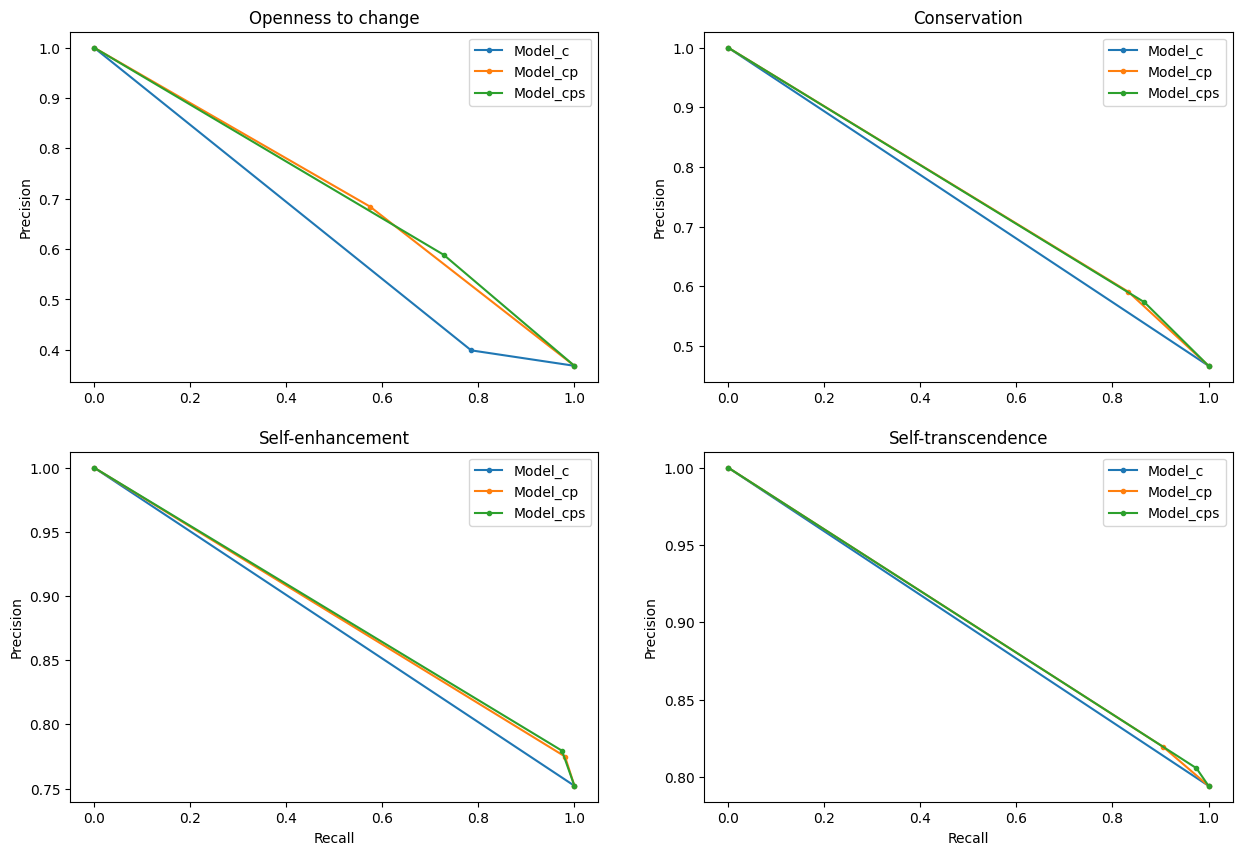

In [48]:
# plot precision/recall curve for the openess to change category


precision_c_opn, recall_c_opn, _ = precision_recall_curve(targets_openness, predictions_openness_c)
precision_cp_opn, recall_cp_opn, _ = precision_recall_curve(targets_openness, predictions_openness_cp)
precision_cps_opn, recall_cps_opn, _ = precision_recall_curve(targets_openness, predictions_openness_cps)
precision_c_con, recall_c_con, _ = precision_recall_curve(targets_conserv, predictions_conserv_c)
precision_cp_con, recall_cp_con, _ = precision_recall_curve(targets_conserv, predictions_conserv_cp)
precision_cps_con, recall_cps_con, _ = precision_recall_curve(targets_conserv, predictions_conserv_cps)
precision_c_enh, recall_c_enh, _ = precision_recall_curve(targets_self_enh, predictions_self_enh_c)
precision_cp_enh, recall_cp_enh, _ = precision_recall_curve(targets_self_enh, predictions_self_enh_cp)
precision_cps_enh, recall_cps_enh, _ = precision_recall_curve(targets_self_enh, predictions_self_enh_cps)
precision_c_trans, recall_c_trans, _ = precision_recall_curve(targets_self_trans, predictions_self_trans_c)
precision_cp_trans, recall_cp_trans, _ = precision_recall_curve(targets_self_trans, predictions_self_trans_cp)
precision_cps_trans, recall_cps_trans, _ = precision_recall_curve(targets_self_trans, predictions_self_trans_cps)

# plot multiple precision-recall curves in (2,2) layout
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(recall_c_opn, precision_c_opn, marker='.', label='Model_c')
axs[0, 0].plot(recall_cp_opn, precision_cp_opn, marker='.', label='Model_cp')
axs[0, 0].plot(recall_cps_opn, precision_cps_opn, marker='.', label='Model_cps')
axs[0, 0].set_title('Openness to change')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].legend()
axs[0, 1].plot(recall_c_con, precision_c_con, marker='.', label='Model_c')
axs[0, 1].plot(recall_cp_con, precision_cp_con, marker='.', label='Model_cp')
axs[0, 1].plot(recall_cps_con, precision_cps_con, marker='.', label='Model_cps')
axs[0, 1].set_title('Conservation')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].legend()
axs[1, 0].plot(recall_c_enh, precision_c_enh, marker='.', label='Model_c')
axs[1, 0].plot(recall_cp_enh, precision_cp_enh, marker='.', label='Model_cp')
axs[1, 0].plot(recall_cps_enh, precision_cps_enh, marker='.', label='Model_cps')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].set_title('Self-enhancement')
axs[1, 0].legend()
axs[1, 1].plot(recall_c_trans, precision_c_trans, marker='.', label='Model_c')
axs[1, 1].plot(recall_cp_trans, precision_cp_trans, marker='.', label='Model_cp')
axs[1, 1].plot(recall_cps_trans, precision_cps_trans, marker='.', label='Model_cps')
axs[1, 1].set_xlabel('Recall')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].set_title('Self-transcendence')
axs[1, 1].legend()
plt.show()

All these curves are pretty linear in nature, the most "curve" looking being the RoBERTa w/CP model on "Openess to change". This means that the models are pretty consistent in their predictions across different thresholds, without favoring precision or recall. 

We also noted that BERT models tend to have this behavior so we think that maybe it is an inherent property of these models.

### Other possible improvements:

- Fine-tuning the models more by training them for more epochs.
- Use different BERT variants.
- Use a weighted loss function.
- Use a different optimizer.
- Use different hyperparameters or doing a thorough grid search for the best ones.
- Try different strategies for the last layers of the models.